In [4]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import spearmanr
import pickle
from tqdm import tqdm
import random

from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION, TWITTER_COUNTS, EMBEDDINGS_PATH, FINAL_DF
from src.data.ambiguity2final import assign_emojipedia_category, assign_our_category
from src.analysis.variation import calculate_vocabulary_variation, embedded_CIs, read_embeddings
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from src.data.utils import parallelize_dataframe

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Compute variation and its confidence

In [20]:
num_cpus = 4

print("Reading data...")
data_path = AMBIGUITY_PATH
embeddings_path = EMBEDDINGS_PATH
emojis = pd.read_csv(data_path, encoding='utf-8')
word_embeddings = read_embeddings(embeddings_path)

print("Preprocessing...")
vocabularies = emojis[["emoji", "word"]] \
    .groupby("emoji").word \
    .apply(list).apply(Counter) \
    .reset_index() \
    .rename({"word": "vocabulary"}, axis=1)

print("Calculating semantic variation in embedding space per emoji...")
vocabularies[["variation", "mode_embedding"]] = vocabularies.apply(lambda row:
                                                                   calculate_vocabulary_variation(row.vocabulary,
                                                                                                  word_embeddings),
                                                                   axis=1,
                                                                   result_type='expand')

print("Bootstrapping...")
CIs = vocabularies.parallel_apply(lambda row: embedded_CIs(calculate_vocabulary_variation,
                                         row.vocabulary, row.mode_embedding,
                                         word_embeddings),
                            axis=1)
vocabularies["CIs"] = CIs

Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...


In [2]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

In [3]:
variations.head()

,emoji,vocabulary,variation,mode_embedding,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,[-9.0013e-01 -4.3639e-03 4.7695e-01 1.4165e-...,"[0.35837585716197884, 0.6267261994754275]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,[ 4.6689e-02 -2.3131e-01 6.4926e-01 -2.9223e-...,"[0.41200086324362406, 0.7542600946038873]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,[-0.10602 -0.010289 -0.25982 0.52433 ...,"[0.1401009645106064, 0.4201737316739228]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,[ 3.6664e-01 -4.0631e-01 2.3680e-01 2.9964e-...,"[0.4139707032711831, 0.7217792813700658]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,[ 0.80197 -1.3284 0.83488 -0.13458 ...,"[0.3517648566963858, 0.6258342967978838]"


In [3]:
flags = [ '🏳️', "🏳️‍🌈", "🏴‍☠️" , "🏴󠁧󠁢󠁥󠁮󠁧󠁿" , "🏴󠁧󠁢󠁳󠁣󠁴󠁿", "🏴󠁧󠁢󠁷󠁬󠁳󠁿" ]
families = ["👨‍👦","👨‍👦‍👦","👨‍👧","👨‍👧‍👦","👨‍👧‍👧","👨‍👨‍👦","👨‍👨‍👦‍👦","👨‍👨‍👧","👨‍👨‍👧‍👦",\
"👨‍👨‍👧‍👧","👨‍👩‍👦","👨‍👩‍👦‍👦","👨‍👩‍👧","👨‍👩‍👧‍👦","👨‍👩‍👧‍👧","👩‍👦","👩‍👦‍👦","👩‍👧",\
"👩‍👧‍👦","👩‍👧‍👧","👩‍👩‍👦","👩‍👩‍👦‍👦","👩‍👩‍👧","👩‍👩‍👧‍👦","👩‍👩‍👧‍👧", "👨‍👩‍👧", "👨‍👩‍👧‍👦", "👨‍👩‍👧‍👧", "👩‍👩‍👧‍👦"]
variations = variations[~variations.emoji.isin(flags)]
variations = variations[~variations.emoji.isin(["🅰️", "🅱️", "🅾️", "🅿️", "🔟"])]
variations = variations[~variations.emoji.isin(families)]

In [4]:
variations.vocabulary = variations.vocabulary.apply(lambda x: x[8:-1])
variations.vocabulary = variations.vocabulary.apply(eval)
variations['vocabulary size'] = variations.vocabulary.apply(len)

### Create baselines

In [23]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
word_embeddings = read_embeddings(EMBEDDINGS_PATH)
words = ambiguity.word

baselines_variation, baselines_vocab_size = [], []
for i in tqdm(range(1000)):
    random_words = words.sample(n=30, random_state=42+i).tolist()
    random_voc = Counter(random_words)
    baselines_vocab_size.append(len(set(random_words)))
    baselines_variation.append(calculate_vocabulary_variation(random_voc, word_embeddings)[0])

alpha = 5
baseline_variation = np.nanmedian(np.array(baselines_variation))
baselines_var_CIs = [np.nanpercentile(baselines_variation, alpha / 2),\
                         np.nanpercentile(baselines_variation, 100 - (alpha / 2))] 

baseline_vocab = np.nanmedian(np.array(baselines_vocab_size))
baselines_vocab_size_CIs = [np.nanpercentile(baselines_vocab_size, alpha / 2),\
                         np.nanpercentile(baselines_vocab_size, 100 - (alpha / 2))] 

100%|██████████| 1000/1000 [00:02<00:00, 340.52it/s]


In [24]:
baseline_variation, baselines_var_CIs

(0.6860900973280272, [0.5707602351453775, 0.8834659105717826])

In [25]:
baseline_vocab, baselines_vocab_size_CIs

(30.0, [27.0, 30.0])

### Figure 1: (RQ1) Relationship between semantic variation (on the x-axis), and vocabulary size (on the y-axis)

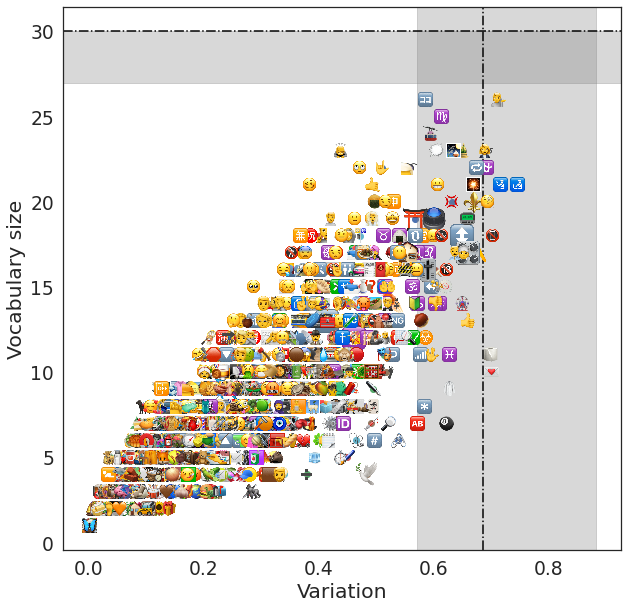

In [26]:
sns.set_color_codes()
sns.set(rc={'figure.figsize':(10, 10)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})

fig, ax = plt.subplots()
df = variations
for x, y, emoji in zip(df['variation'], df['vocabulary size'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.axvline(baseline_variation, color='black', linestyle='-.')
ax.axvspan(baselines_var_CIs[0],
             baselines_var_CIs[1], alpha=0.3, color='gray')

ax.axhline(baseline_vocab, color='black', linestyle='-.')
ax.axhspan(baselines_vocab_size_CIs[0],
             baselines_vocab_size_CIs[1], alpha=0.3, color='gray')

ax.set_xlabel("Variation")
ax.set_ylabel("Vocabulary size")
plt.savefig('../figures/variationVSvocabulary.png', dpi=300, transparent=False, bbox_inches='tight');

In [6]:
spearmanr(variations.variation.values, variations["vocabulary size"].values)

SpearmanrResult(correlation=0.8424604652072131, pvalue=0.0)

### Figure 2: (RQ2) Average semantic variation (top) and average vocabulary size (bottom) across emoji categories

In [12]:
variations["category"] = variations.emoji.apply(assign_emojipedia_category)
variations["category"] = variations.apply(assign_our_category, axis=1)
variations = variations.replace({"symbols": "symbols & signs"})

In [14]:
sns.set(rc={'figure.figsize':(8, 16)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

sns.set_palette("tab10", 20)

order1 = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
sns.barplot(y='category', x='variation', data=variations, ax=ax1, order=order1)
ax1.set_ylabel("Category")
ax1.set_xlabel("Average variation")

ax1.axvline(baseline_variation, color='black', linestyle='-.')
ax1.axvspan(baselines_var_CIs[0],
             baselines_var_CIs[1], alpha=0.3, color='gray')


order2 = variations.groupby("category")["vocabulary size"].mean().sort_values(ascending=False).index.tolist()
pal = sns.color_palette()
color_map = dict(zip(order1, pal.as_hex()))
palette = [color_map[bar] for bar in order2]

sns.barplot(y='category', x='vocabulary size', data=variations, ax=ax2, order=order2, palette=palette)
ax2.set_ylabel("Category")
ax2.set_xlabel("Average vocabulary size")

ax2.axvline(baseline_vocab, color='black', linestyle='-.')
ax2.axvspan(baselines_vocab_size_CIs[0],
             baselines_vocab_size_CIs[1], alpha=0.3, color='gray');

plt.savefig('../figures/emojiCategories.png', dpi=300, transparent=False, bbox_inches='tight');

### Table 1: Emoji categorization

In [62]:
df1 = variations.groupby("category").emoji.count().sort_values(ascending=False)\
            .to_frame().rename({"emoji": "Number"}, axis=1)

In [71]:
df2 = variations.groupby("category").emoji.apply(list).apply(lambda x: random.choices(x, k=3))\
            .to_frame().rename({"emoji": "Examples"}, axis=1)

In [72]:
df1.join(df2)

,Number,Examples
category,,
objects,202,"[📰, 📮, 🕰️]"
nature,189,"[🦅, 🌔, 🦧]"
travel-places,129,"[🚌, 🚡, 🌉]"
food-drink,113,"[🥣, 🍓, 🍫]"
faces,111,"[😥, 🤮, 🤣]"
people,103,"[👨‍🦽, 🧍, 🩸]"
activity,78,"[🎰, 🥎, 🎫]"
clothes & accessories,47,"[🥿, 🧳, 🧵]"
symbols & signs,43,"[💯, ➕, 🎵]"


### Figure 3: (RQ3) Relationship between Twitter emoji frequency (on the y-axis) and semantic variation (on the x-axis)

In [17]:
twitter_count = pd.read_csv(FINAL_DF).groupby("emoji").twitter_count.first().reset_index()
variations = pd.merge(variations, twitter_count, on='emoji', how='left')\
                    .rename({"count": "twitter_count"}, axis=1)

In [18]:
sns.set(rc={'figure.figsize':(12, 12)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})

df = variations

fig, ax = plt.subplots()
df = variations
for x, y, emoji in zip(df['variation'], df['twitter_count'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.axvline(baseline_variation, color='black', linestyle='-.')
ax.axvspan(baselines_var_CIs[0],
             baselines_var_CIs[1], alpha=0.3, color='gray')

ax.set_yscale("log")
ax.set_xlabel("Variation")
ax.set_ylabel("Twitter count (log)")
plt.tight_layout()
plt.savefig('../figures/variationVStwitterCount.png', dpi=300, transparent=False, bbox_inches='tight');

NameError: name 'baseline_variation' is not defined

Error in callback <function flush_figures at 0x7f6b30d5dc80> (for post_execute):


KeyboardInterrupt: 